# Building a Euribor Curve - Interpolation Analysis - Complex Case

We build an Ibor single-curve and examine different interpolation choices for a simple curve.

This follows:

https://quant.stackexchange.com/questions/53904/monotonic-cubic-spline-interpolation-quantlib-python?rq=1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from financepy.utils import *
from financepy.products.rates import *

####################################################################
# FINANCEPY BETA Version 0.185 - This build:  29 Oct 2020 at 09:34 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



In [4]:
valuation_date = Date(12, 5, 2020)

## Building the Single Curve

Build the Ibor Curve

In [5]:
# Need to specify a UK calendar (trade was done in London)
cal = CalendarTypes.UNITED_KINGDOM

depoDCCType = DayCountTypes.ACT_360
depos = []
spot_days = 2
settlement_date = valuation_date.add_weekdays(spot_days)
depo = IborDeposit(settlement_date, "6M", -0.496/100.0, depoDCCType, calendar_type=cal); depos.append(depo)
fraDCCType = DayCountTypes.ACT_360

fras = []
fra = IborFRA(settlement_date.add_tenor("1M"), "6M", -0.493/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("2M"), "6M", -0.491/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("3M"), "6M", -0.494/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("4M"), "6M", -0.496/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("5M"), "6M", -0.499/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("6M"), "6M", -0.501/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("7M"), "6M", -0.505/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("8M"), "6M", -0.508/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("9M"), "6M", -0.518/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("10M"), "6M", -0.516/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("11M"), "6M", -0.518/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("12M"), "6M", -0.519/100.0, fraDCCType, calendar_type=cal); fras.append(fra)

swaps = []
swapType = SwapTypes.PAY
fixedDCCType = DayCountTypes.THIRTY_E_360_ISDA
fixedFreqType = FrequencyTypes.SEMI_ANNUAL

swap = IborSwap(settlement_date, "2Y", swapType, -0.514/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "3Y", swapType, -0.506/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "4Y", swapType, -0.482/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "5Y", swapType, -0.451/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "6Y", swapType, -0.415/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "7Y", swapType, -0.375/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "8Y", swapType, -0.333/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "9Y", swapType, -0.288/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "10Y", swapType, -0.242/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "11Y", swapType, -0.198/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "12Y", swapType, -0.156/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "15Y", swapType, -0.054/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "20Y", swapType, 0.023/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "25Y", swapType, 0.023/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "30Y", swapType, -0.005/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "40Y", swapType, -0.063/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "50Y", swapType, -0.113/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)

iborDepos = depos.copy()
iborFras = fras.copy()
ibor_swaps = swaps.copy()

In [10]:
iborCurves = {}
for interp_type in InterpTypes:
    iborCurve = IborSingleCurve(valuation_date, iborDepos, iborFras, ibor_swaps, interp_type)
    iborCurves[interp_type] = iborCurve

## Curve Shape Analysis

Look at short end

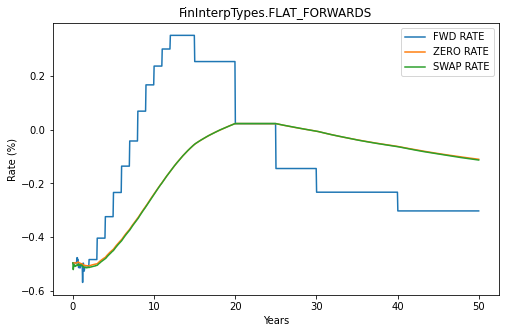

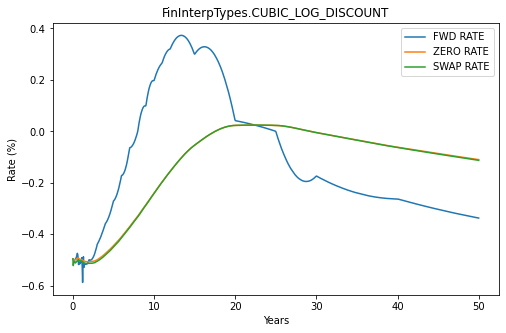

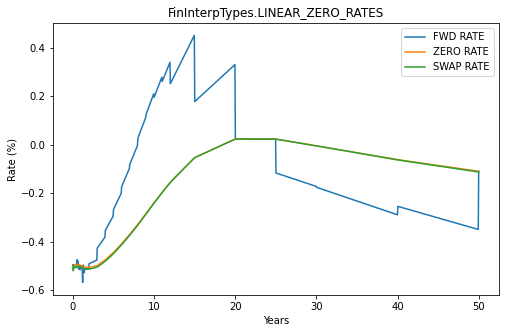

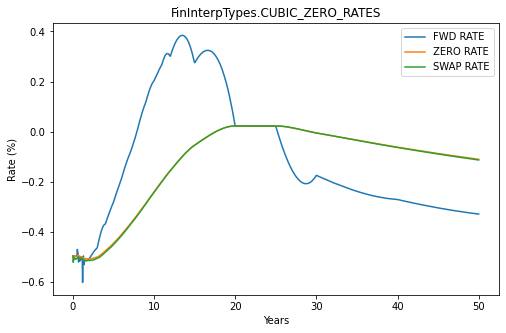

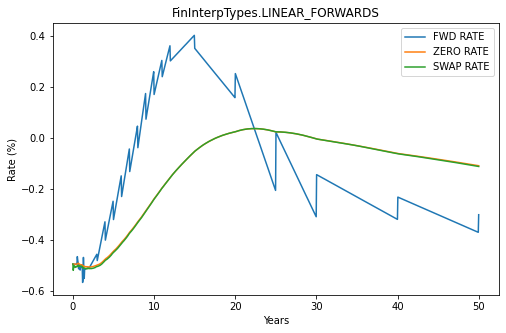

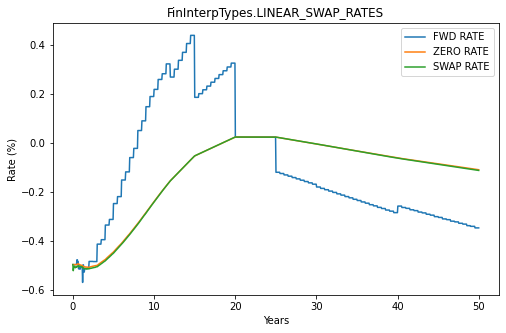

In [13]:
years = np.linspace(0.01, 50, 1000)
plotDates = settlement_date.add_years(years)

for interp_type in InterpTypes:

    plt.figure(figsize=(8,5))
    iborCurve = iborCurves[interp_type]
    iborCurveFwdRate = iborCurve.fwd_rate(plotDates, "1D")
    iborCurveZeroRate = iborCurve.zero_rate(plotDates)
    iborCurveSwapRate = iborCurve.swap_rate(settlement_date, plotDates)
    
    plt.plot(years, iborCurveFwdRate*100.0, label="FWD RATE")
    plt.plot(years, iborCurveZeroRate*100.0, label="ZERO RATE")
    plt.plot(years, iborCurveSwapRate*100.0, label="SWAP RATE")

    plt.title(interp_type)
    plt.xlabel("Years")
    plt.ylabel("Rate (%)")
    plt.legend();

Copyright (c) Dominic O'Kane 2020